Notebook with the design of the Core Simulation class, Conventional radio and Cognitive Radio v1

In [1]:
class Simulation:    
    import numpy as np
    import pandas as pd     
    import seaborn as sns
    
    def __init__(self,channels=10,granularity=1,cycles=720):        
        self.channels = channels
        self.granularity = granularity
        self.cycles = cycles
        self.radios = []
        self.sfdf = pd.DataFrame(np.zeros((cycles, channels)))            
        
    def addRadio(self,radio, channel):
        self.radios.append(radio)
        self.sfdf[channel] = radio.generate()
        
    def addCognitiveRadio(self,radio):
        self.radios.append(radio)
        self.sfdf = radio.generate()
        
    def run(self):
        print("Begin Simulation")
        print("Network :")
        for ra in self.radios:
            print (ra.describe())
            
        
        total_clashes = self.sfdf[self.sfdf > 1].count().sum()
        total_blocks = self.sfdf.count().sum()
        self.Confidence = 1 - float(total_clashes)/total_blocks
        
        print( "Network Confidence : " + str(self.Confidence*100) +"%")
        
        used_blocks = self.sfdf[self.sfdf > 0].count().sum()
        self.Eficiency = float(used_blocks)/total_blocks
        
        print( "Spectrum Eficieny : " + str(self.Eficiency*100) +"%")
        
        self.plot()
        
    def plot(self):
        print( "Method to plot and present results")
        test = math.floor(self.cycles * 0.3)
        ax = sns.heatmap(self.sfdf[-test:], vmax=self.sfdf[-test:].max().max(), cmap="YlGnBu")
        fig = ax.get_figure()
        fig.savefig('plot.png')
        
    
        

In [2]:
class ConventionalRadio:
    
    import numpy as np
    def __init__(self,period,cycles,channel):
        self.period = period
        self.cycles = cycles
        self.channel = channel
        
    def generate(self):
        tmp_period= abs(self.period)
        usage = np.ones(self.cycles, dtype = 'float')
        on_period= np.ones(tmp_period)
        off_period = np.zeros(tmp_period)
        true_usage = np.tile(np.concatenate((on_period, off_period), axis=0),int(self.cycles/(2*tmp_period)))
        true_usage = true_usage if self.period>0 else usage
        return true_usage
    def describe(self):
        return "Conventional Radio with Period " + str(self.period) + " located in channel " + str(self.channel)
        

In [3]:
class RandomRadio:
    
    import numpy as np
    def __init__(self,period,cycles,channel):
        self.period = period
        self.cycles = cycles
        self.channel = channel
        
    def generate(self):
        
        return np.random.randint(2, size=self.cycles)
    #608899
    def describe(self):
        return "Random Radio with Period " + str(self.period) + " located in channel " + str(self.channel)
        

In [4]:
class CognitiveRadio_v1:
    
    import numpy as np
    def __init__(self,spec):
        self.df = spec
        self.channels = len(spec.columns)
        self.current = 0
        
    def update(self, current):
        self.current = current
                             
        
    def generate(self):
        
        for index, row in self.df.iterrows():                         
            free_channels = row[row==0].index.values
            busy_channels = row[row>0 ].index.values
            
            row[self.current] = row[self.current]+1  

            if self.current in busy_channels:
                # Change Channel 
                left = free_channels[free_channels > self.current]
                right = free_channels[free_channels < self.current]

                if len(left)>0:
                    self.current = left.min()
                elif len(right)> 0:
                    self.current = right.min()
                else:
                    self.current = self.current                                                            
            
            
        
        return self.df
                
    def describe(self):
        return "Cognitive Radio v1 located in the network " 

In [5]:
class CognitiveRadio_v2:
    
    import numpy as np
    import math
    from keras.models import Sequential
    from keras.layers import Dense
    from keras.layers import LSTM, Activation, GRU
    
    def __init__(self,spec, train=0.7, lookback = 6):
        self.df = spec
        self.channels = len(spec.columns)
        self.current = 0
        self.train = train              
        self.lookback = lookback
        self.pred_df = pd.DataFrame(0, columns=spec.columns, index=spec.index)
        
        
    def update(self, current):
        self.current = current
        
    
    def reshape_data(self,x,y, lookback):
        
        shaped = np.zeros(shape=(len(x)-lookback,lookback,1))
        y_shaped = np.zeros(shape =(len(x)-lookback,1) )
    
        for sample in range(len(x) - lookback) :
            seq = x[sample: sample+lookback]
            shaped[sample,:,0] = seq
            y_shaped[sample] = y[sample+lookback]

        return shaped,y_shaped
    
    def transform_data(self):
        # Transform data to busy/free 
        self.df = self.df[self.df == 0 ].fillna(1)
        
    def split_data(self, data, spl):
        # Split dataset into validation and training        
        split = math.floor(data.shape[0] * spl)
        #train_y = data.shift().drop(data.index[:1])
        #data = data.drop(data.index[:1])
        
        
        train_x, valid_x = data[:split], data[split:]           
        train_y , valid_y = data[:split], data[split:]
        
        return train_x.values,valid_x.values,train_y.values,valid_y.values
                             
    def create_model(self):
        
        model = Sequential()
        model.add(LSTM(5, input_shape=(self.lookback, 1)))        
        #self.model.add(GRU(10, input_shape=(self.lookback, 1)))        
        model.add(Dense(1, activation='sigmoid'))   
        
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        
        return model
        
    def train_model(self,model):
               
        history = model.fit(self.train_x, self.train_y,
                                      validation_data=(self.valid_x, self.valid_y), 
                                      epochs=10, batch_size=1, verbose=0, shuffle=False)
        
        return history            
                
    def score_model(self, x, index, model ):
        self.modelout = model.predict_classes(x)
        #pred = pd.Series(model.predict_classes(x).ravel().tolist() ,index=index)        
        pred = pd.Series(model.predict_classes(x).ravel().tolist(), index=index)
        return pred
    
    def generate_activity(self, samples):        
        
        for index, row in self.pred_df.iterrows():    
            
            if index < samples:
                continue
            free_channels = row[row==0].index.values
            busy_channels = row[row>0 ].index.values                        

            if self.current in busy_channels:
                # Change Channel 
                left = free_channels[free_channels > self.current]
                right = free_channels[free_channels < self.current]

                if len(left)>0:
                    self.current = left.min()
                elif len(right)> 0:
                    self.current = right.min()
                else:
                    self.current = self.current   
                    
            self.df.loc[index,self.current] = self.df.loc[index,self.current]+1  
        
    def generate(self):
        
        self.transform_data()
        self.models = []
        self.history = []
        
        for channel in self.df.columns:                        
                    
            train_x,valid_x,train_y,valid_y = self.split_data(self.df[channel], self.train)              
            
                                    
            self.train_x, self.train_y = self.reshape_data(train_x,train_y ,self.lookback)            
            self.valid_x, self.valid_y = self.reshape_data(valid_x,valid_y,self.lookback)            
                    
            # Create and train model 

            self.models.append(self.create_model())
            self.history.append(self.train_model(self.models[channel]))
            
            index = pd.RangeIndex(start=self.pred_df[0].shape[0] - self.valid_x.shape[0]  , stop=self.pred_df[0].shape[0] , step=1)
            
            pred = self.score_model(self.valid_x, index,self.models[channel])
            
            self.pred_df[channel] = self.pred_df[channel].add(pred, fill_value=1)
            
        self.generate_activity(self.pred_df[0].shape[0] - self.valid_x.shape[0])
                                                            
        
        return self.df
                
    def describe(self):
        return "Cognitive Radio v2 located in the network " 

Using TensorFlow backend.


## Montecarlo Run 

1.- 10 total runs
2.- Average each metric


32/99 [========>.....................] - ETA: 0ssBegin Simulation
Network :
Random Radio with Period 1 located in channel 0
Random Radio with Period 1 located in channel 1
Random Radio with Period 1 located in channel 2
Random Radio with Period 1 located in channel 3
Random Radio with Period 1 located in channel 4
Random Radio with Period 1 located in channel 5
Random Radio with Period 1 located in channel 6
Random Radio with Period 1 located in channel 7
Random Radio with Period 1 located in channel 8
Random Radio with Period 1 located in channel 9
Cognitive Radio v2 located in the network 
Network Confidence : 98.25%
Spectrum Eficieny : 51.4444444444%
Method to plot and present results
Finished Montecarlo run 0 in 477.7582550048828!
32/99 [========>.....................] - ETA: 0ssBegin Simulation
Network :
Random Radio with Period 1 located in channel 0
Random Radio with Period 1 located in channel 1
Random Radio with Period 1 located in channel 2
Random Radio with Period 1 located 

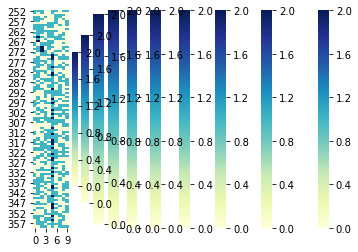

In [31]:
import random
import numpy as np
import pandas as pd  
import seaborn as sns
import math 
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from tensorflow.contrib import learn
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Activation, GRU
from keras.callbacks import EarlyStopping, ModelCheckpoint

%matplotlib inline

periods = [-1, 1 , 2 , 4 , 6 ,12 ] # possible periods for conventional radios
total_bands = 10 
runs = 10 

random_sources = 10
add_Cognitive_v1 = False
add_Cognitive_v2 = True
radios = []
training_loss = {}
training_acc = {}
test_loss = {}
test_acc = {}
eff = {}


days = 15
total_cycles = days*24
result_df = pd.DataFrame(columns=['epoch','loss','acc', 'type'])
result_df_2 = pd.DataFrame(columns=['Efficiency','Confidence'])

sns.set_palette(sns.color_palette("coolwarm", 7))

for MonteCount in range(runs):
    
    start = time.time()
    MonteCarloSim = Simulation(cycles=total_cycles)

    for radio_channel in range(total_bands - random_sources):
        selected_period = random.choice(periods)
        c_radio= ConventionalRadio(selected_period,total_cycles,radio_channel)
        MonteCarloSim.addRadio(c_radio,radio_channel)

    for radio_channel in range(total_bands - random_sources, total_bands):
        c_radio= RandomRadio(selected_period,total_cycles,radio_channel)
        MonteCarloSim.addRadio(c_radio,radio_channel)

    if add_Cognitive_v1:
        radioc = CognitiveRadio_v1(MonteCarloSim.sfdf)
        MonteCarloSim.addCognitiveRadio(radioc)
    if add_Cognitive_v2:
        radioc2 = CognitiveRadio_v2(MonteCarloSim.sfdf, lookback=10)
        MonteCarloSim.addCognitiveRadio(radioc2)

    MonteCarloSim.run()

    if add_Cognitive_v2:    
        for i in range(runs):            
            epochs = len(radioc2.history[i].history['loss'])
            eps = [x for x in range(1,epochs+1)]
            vlabel = ['val' for x in range(1,epochs+1)]
            tlabel = ['training' for x in range(1,epochs+1)]
            
            tloss =  radioc2.history[i].history['loss']
            tacc = radioc2.history[i].history['acc']
            
            result_df= result_df.append(pd.DataFrame({'loss':tloss,'acc':tacc,
                                                      'epoch':eps , 'type':tlabel}),
                                        ignore_index=True)

            vloss =  radioc2.history[i].history['val_loss']
            vacc = radioc2.history[i].history['val_acc']
            
            result_df= result_df.append(pd.DataFrame({'loss':vloss,'acc':vacc,
                                                      'epoch':eps , 'type':vlabel}),
                                        ignore_index=True)


    end = time.time()
    result_df_2 = result_df_2.append(pd.DataFrame({'Efficiency': [MonteCarloSim.Eficiency],
                                                   'Confidence':[MonteCarloSim.Confidence]}),
                                    ignore_index=True)
    
    print("Finished Montecarlo run {0} in {1}!".format(MonteCount, end - start))
    
    


        
    


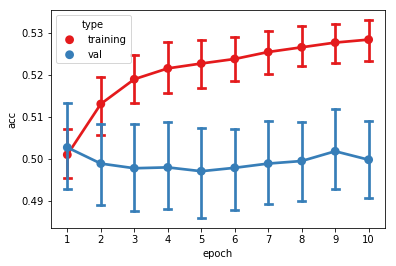

In [32]:
import matplotlib.pyplot as plt
ax = sns.pointplot()
ax=sns.pointplot(x="epoch", y="acc",hue='type', data=result_df, capsize=.2, palette="Set1")
plt.show()

In [33]:
fig = ax.get_figure()
fig.savefig('RandomValAccv1v2.png')

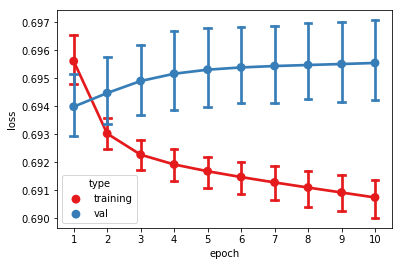

In [34]:
ax=sns.pointplot(x="epoch", y="loss",hue='type', data=result_df, capsize=.2, palette="Set1")
plt.show()

In [35]:
fig = ax.get_figure()
fig.savefig('RandomValLossv1v2.png')

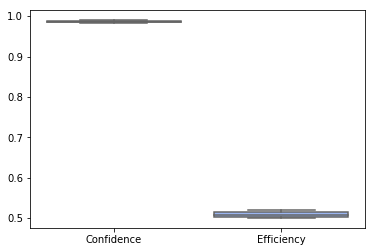

In [36]:
ax = sns.boxplot(data=result_df_2)


In [37]:
fig = ax.get_figure()
fig.savefig('RandomEffvConfv2.png')

In [13]:
result_df_2

,Confidence,Efficiency
0,0.993333,0.573056
1,0.985278,0.611667
2,0.985556,0.564167
3,0.986667,0.616389
4,0.983333,0.515000
5,0.995556,0.572222
6,0.986389,0.664167
7,0.997778,0.632222
8,0.987778,0.558333
9,0.995000,0.622500


In [14]:
epochs = len(radioc2.history[i].history['loss'])
x1 = radioc2.history[i].history['loss']
x2 = radioc2.history[i].history['loss']
x3 = radioc2.history[i].history['loss']
x4 = radioc2.history[i].history['loss']
eps = [x for x in range(1,epochs+1)]
result_df= result_df.append(pd.DataFrame({'training_loss':x1,'training_acc':x2, 'val_loss':x3,'val_acc':x4,'epoch':eps}), ignore_index=True)
print(result_df)

           acc epoch      loss  training_acc  training_loss      type  \
0     0.502075     1  0.710325           NaN            NaN  training   
1     0.502075     2  0.693351           NaN            NaN  training   
2     0.502075     3  0.672991           NaN            NaN  training   
3     0.535270     4  0.628816           NaN            NaN  training   
4     1.000000     5  0.529720           NaN            NaN  training   
5     1.000000     6  0.415393           NaN            NaN  training   
6     1.000000     7  0.316740           NaN            NaN  training   
7     1.000000     8  0.246985           NaN            NaN  training   
8     1.000000     9  0.197342           NaN            NaN  training   
9     1.000000    10  0.157181           NaN            NaN  training   
10    0.494949     1  0.702455           NaN            NaN       val   
11    0.494949     2  0.685965           NaN            NaN       val   
12    0.494949     3  0.659160           NaN       

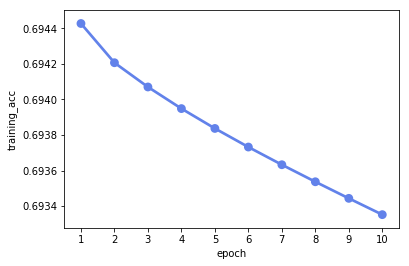

In [15]:
ax = sns.pointplot(x="epoch", y="training_acc", data=result_df)

## LSTM Design

In [6]:
import numpy as np
import pandas as pd  
import seaborn as sns
import math 
%matplotlib inline

days = 15
total_cycles = days*24


test = Simulation(cycles=total_cycles)
radio1= ConventionalRadio(1,total_cycles,1)
test.addRadio(radio1,1)
radio2= ConventionalRadio(-1,total_cycles,2)
test.addRadio(radio2,2)
radio3= ConventionalRadio(4,total_cycles,3)
test.addRadio(radio3,3)
radio4= ConventionalRadio(2,total_cycles,4)
test.addRadio(radio4,4)
radio5= ConventionalRadio(6,total_cycles,5)
test.addRadio(radio5,5)
radio6= ConventionalRadio(12,total_cycles,6)
test.addRadio(radio6,6)
radio7= ConventionalRadio(1,total_cycles,7)
test.addRadio(radio7,7)
radio8= ConventionalRadio(4,total_cycles,8)
test.addRadio(radio8,8)
radio9= ConventionalRadio(-1,total_cycles,9)
test.addRadio(radio9,9)
radio0= ConventionalRadio(4,total_cycles,0)
test.addRadio(radio0,0)
radioc = CognitiveRadio_v1(test.sfdf)
c2 = CognitiveRadio_v2(test.sfdf, lookback=10)
#test.addCognitiveRadio(radioc)
test.addCognitiveRadio(c2)

test.run()

NameError: name 'Sequential' is not defined

In [17]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from tensorflow.contrib import learn
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Activation, GRU
from keras.callbacks import EarlyStopping, ModelCheckpoint


In [18]:
df = test.sfdf
for colum in df.columns:
    print(type(df[colum]))
    break

<class 'pandas.core.series.Series'>


In [19]:
radioc2.history[0].history

{'acc': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'loss': [0.23262150495997108,
  0.04320269981515111,
  0.015013297161868005,
  0.0076922169187071416,
  0.0054789556719795551,
  0.0042398904761322678,
  0.0033592206988236344,
  0.002711375575334885,
  0.0022213369505518577,
  0.0018420886432875675],
 'val_acc': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'val_loss': [0.07636570930480957,
  0.023431530222296715,
  0.010043824091553688,
  0.0062624397687613964,
  0.0047830110415816307,
  0.0037506737280637026,
  0.0030026771128177643,
  0.0024436740204691887,
  0.0020154749508947134,
  0.0016805336344987154]}

In [20]:
c2.df.tail()

,0,1,2,3,4,5,6,7,8,9
355,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
356,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
357,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
358,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
359,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0


In [21]:
test.sfdf.tail()

,0,1,2,3,4,5,6,7,8,9
355,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
356,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
357,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
358,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
359,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0


In [22]:
tt= c2.models[0].predict_classes(c2.valid_x).ravel().tolist()
tt1 = c2.valid_x
tt2 = c2.valid_y
tt3 = c2.df[0][-99:]

32/99 [========>.....................] - ETA: 0s

In [23]:
tt[-5:]

[1, 1, 1, 1, 1]

In [24]:
tt3.head()

261    1.0
262    1.0
263    1.0
264    2.0
265    1.0
Name: 0, dtype: float64

In [25]:
tt = pd.Series(c2.models[0].predict_classes(c2.valid_x).ravel().tolist()[::-1])[:-1]        
tt.index

32/99 [========>.....................] - ETA: 0s

RangeIndex(start=0, stop=98, step=1)

In [26]:
def generate_activity(pred_df):
        current= 0
        for index, row in pred_df.iterrows():                         
            free_channels = row[row==0].index.values
            busy_channels = row[row>0 ].index.values     
            print(index)

            if current in busy_channels:
                # Change Channel 
                left = free_channels[free_channels > current]
                right = free_channels[free_channels < current]

                if len(left)>0:
                    current = left.min()
                elif len(right)> 0:
                    current = right.min()
                else:
                    current = current   
                
            

Begin Simulation
Network :
Conventional Radio with Period 1 located in channel 1
Conventional Radio with Period -1 located in channel 2
Conventional Radio with Period 4 located in channel 3
Conventional Radio with Period 2 located in channel 4
Conventional Radio with Period 6 located in channel 5
Conventional Radio with Period 12 located in channel 6
Conventional Radio with Period 1 located in channel 7
Conventional Radio with Period 4 located in channel 8
Conventional Radio with Period -1 located in channel 9
Conventional Radio with Period 4 located in channel 0
Cognitive Radio v1 located in the network 
Cognitive Radio v2 located in the network 
Network Confidence : 99.5555555556%
Spectrum Eficieny : 69.8055555556%
Method to plot and present results


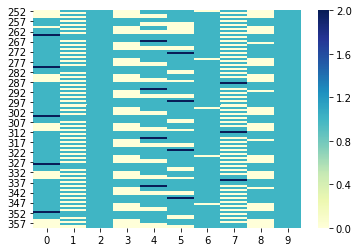

In [27]:
test.run()